# Project: Predict Income with Random Forest

In this project, I will be using a dataset containing census information from UCI’s Machine Learning Repository. By using this census data with a random forest, I will try to predict whether or not a person makes more than $50,000. The original data set is available at the UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/census+income

Let's load data and answer few question first:

What are the numbers of columns and records?
what percentage of samples have incomes less than 50k and greater than 50k?
What are the features from the first person in this data?


In [242]:
import pandas as pd
import numpy as np

col_names = ['age', 'workclass', 'fnlwgt','education', 'education-num', 
'marital-status', 'occupation', 'relationship', 'race', 'sex',
'capital-gain','capital-loss', 'hours-per-week','native-country', 'income']

data = pd.read_csv('adult.data', header=None, names=col_names)
print(data.info())

print(data.shape)

print(data.income.value_counts(normalize=True))

print(data.iloc[0,:])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None
(32561, 15)
 <=50K    0.75919
 >50K     0.24081
Name: income, dtype: float64
age        

I already fixed lack of `columns` name but there is another problem with this data -- every `string` has an extra space at the start. For example, the first row’s native-country is “ United-States”, but we want it to be “United-States”. Python `strip` functions remove characters or white spaces from the beginning or end of a string

Let's fix that using `strip`. 

In [243]:
for x in data.select_dtypes(include=['object']).columns:
    data[x] = data[x].str.strip()

Now I have pick few features for further analysis. For now I will be interested in age, capital-gain and lose, hours-per-week, sex and race. Then convert categorical features to dummy variables using `pd.get_dummies()`

In [244]:
feature_cols = ['age', 'capital-gain', 'capital-loss', 'hours-per-week', 'sex','race']

X = pd.get_dummies(data[feature_cols], drop_first=True)
print(X.columns)

print(data['income'].value_counts())

Index(['age', 'capital-gain', 'capital-loss', 'hours-per-week', 'sex_Male',
       'race_Asian-Pac-Islander', 'race_Black', 'race_Other', 'race_White'],
      dtype='object')
<=50K    24720
>50K      7841
Name: income, dtype: int64


Change `income` column for `1` if income > 50k and `0` if income <=50k. It will be `y` variable in further machine learning analysis

In [245]:
data['income'] = data['income'].apply(lambda row: 1 if row == '>50K' else 0)
y = data['income']

print(y.value_counts())

0    24720
1     7841
Name: income, dtype: int64


Let's split the data into `training` and `testing` sets

In [246]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

Now lets make an instance of a `RandomForestClassifier()` (with `default parameters`). Fit the model on the `train data` and print the `accuracy` score on the `test data`. This will act as a baseline to compare other model performances. Also let's check some more details about importance of each feature.

In [247]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier()

forest.fit(X_train, y_train)

score = forest.score(X_test, y_test)

print(forest.n_features_in_)
print(forest.feature_names_in_)
print(forest.feature_importances_)
print(f'Accuracy score for default random forest: {round(score * 100, 3)}%')


9
['age' 'capital-gain' 'capital-loss' 'hours-per-week' 'sex_Male'
 'race_Asian-Pac-Islander' 'race_Black' 'race_Other' 'race_White']
[0.32206975 0.28633547 0.11436332 0.19599978 0.05882706 0.00486119
 0.00763629 0.00203321 0.00787392]
Accuracy score for default random forest: 81.913%


Using default `hyperparameters` random forest model got about 82% accuracy which is not bad at all. Whatmore, We can see that `age`, `capital-gain` and `hours-per-week` are 3 most important features, which make perfect sense. With age people geting more experiene and better paying jobs and working for more hours mean more work done.


Now let's see if I can get better accuracy by `tuning hyperparameters`. I will explore tuning the random forest classifier model by testing the performance over a range of `max_depth values`. Fit a random forest classifier for `max_depth values from 1-25`. Save the accuracy score for the train and test sets in the lists accuracy_train, accuracy_test.

In [248]:
from sklearn.metrics import accuracy_score
accuracy_train = []
accuracy_test = []
depths = range(1, 26)

for k in depths:
    rf = RandomForestClassifier(max_depth=k, random_state=1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_train)
    accuracy_test.append(rf.score(X_test, y_test))
    accuracy_train.append(rf.score(X_train, y_train))

best_acc = np.max(accuracy_test)
best_depth = depths[np.argmax(accuracy_test)]




print(f'The highest accuracy on the test is achieved when depth: {best_depth}')
print(f'The highest accuracy on the test set is: {round(best_acc*100, 3)}%')


    
    

The highest accuracy on the test is achieved when depth: 12
The highest accuracy on the test set is: 83.433%


Now let's plot the results using `Matplotlib`

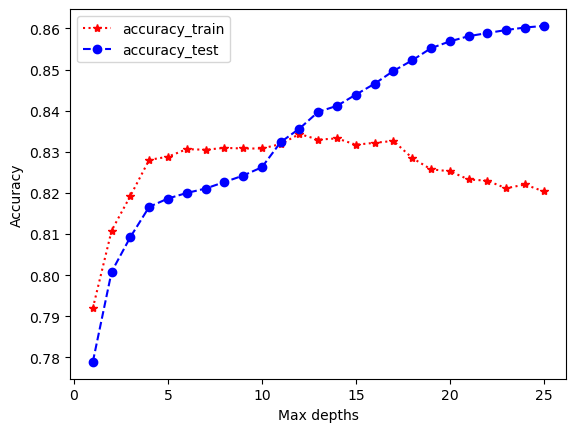

In [249]:
from matplotlib import pyplot as plt   

plt.plot(depths, accuracy_test, 'r*:', depths, accuracy_train, 'bo--')
plt.legend(['accuracy_train' , 'accuracy_test'])
plt.xlabel('Max depths')
plt.ylabel('Accuracy')
plt.show()

Now we have `best depth value` so let's apply it to Random forest model and make `Best Random Forest`. Then I will check what are the `most important features` and what are their `values`. 

In [250]:
best_rf = RandomForestClassifier(max_depth=best_depth)
best_rf.fit(X_train, y_train)

feature_imp_df = pd.DataFrame(zip(X_train.columns, best_rf.feature_importances_),  columns=['feature', 'importance'])

print('Top 5 random forest features:')
print(feature_imp_df.sort_values('importance', ascending=False).iloc[0:5])

Top 5 random forest features:
          feature  importance
1    capital-gain    0.370640
0             age    0.243741
3  hours-per-week    0.143979
2    capital-loss    0.139283
4        sex_Male    0.081831


# Create Additional Features and Re-Tune

Now let's step back. In previous model I did not take into account at education feature. Now, lets do another model but this time including this feature. Looking at it, there are 16 unique values – from preschool to professional school. It would not make sense adding dummy variables for each value as then I would be left with too many variables. It makes sense to bin some of these values together. I will take the approach of combining the values into 3 groups: `High school or less`, `College to Bachelors` and `Masters or more`. 

In [251]:
education_features = pd.DataFrame(data[['education', 'education-num']].value_counts())
print(education_features.sort_values(by='education-num'))


                                0
education    education-num       
Preschool    1                 51
1st-4th      2                168
5th-6th      3                333
7th-8th      4                646
9th          5                514
10th         6                933
11th         7               1175
12th         8                433
HS-grad      9              10501
Some-college 10              7291
Assoc-voc    11              1382
Assoc-acdm   12              1067
Bachelors    13              5355
Masters      14              1723
Prof-school  15               576
Doctorate    16               413


As we see above. Education-num 1-9 will be `High School or less` 10-13 will be `College to bachelors` and 13-16 will be `Masters or more`. Lets divide them into these group

In [252]:
data['education_bin'] = pd.cut(data['education-num'], [0,9,13,16], labels=['HS or less', 'College to Bachelors', 'Masters or more'])

print(data['education_bin'].value_counts())

College to Bachelors    15095
HS or less              14754
Masters or more          2712
Name: education_bin, dtype: int64


Let's save new features as `feature_cols`

In [253]:
feature_cols = ['age',
       'capital-gain', 'capital-loss', 'hours-per-week', 'sex', 'race','education_bin']

And as before get numbers from categorical variables using `get_dummy`

In [254]:
X2 = pd.get_dummies(data[feature_cols], drop_first=True)

Split our data

In [255]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, random_state=1, test_size=0.2)

And as before find best `max depth` and establish ` Best Random Forest Model`

In [256]:
accuracy_train2 = []
accuracy_test2 = []
depths = range(1, 26)

for k in depths:
    rf = RandomForestClassifier(max_depth=k)
    rf.fit(X2_train, y2_train)
    accuracy_test2.append(rf.score(X2_test, y2_test))
    accuracy_train2.append(rf.score(X2_train, y2_train))
    
best_acc2 = np.max(accuracy_test2)
best_depth2 = depths[np.argmax(accuracy_test2)]

print(f'The highest accuracy on the test is achieved when depth: {best_depth}')
print(f'The highest accuracy on the test set is: {round(best_acc*100, 3)}%')

The highest accuracy on the test is achieved when depth: 12
The highest accuracy on the test set is: 83.433%


Then plot results

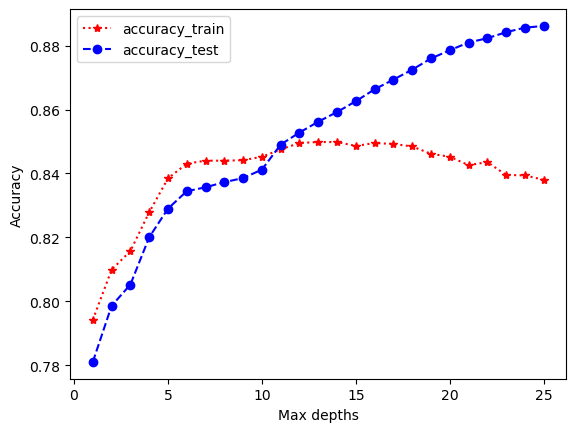

In [257]:

plt.plot(depths, accuracy_test2, 'r*:', depths, accuracy_train2, 'bo--')
plt.legend(['accuracy_train' , 'accuracy_test'])
plt.xlabel('Max depths')
plt.ylabel('Accuracy')
plt.show()

And create `Best Random Forest Model`, then check what `features are most important`.

In [258]:
best_rf2 = RandomForestClassifier(max_depth=best_depth2)
best_rf2.fit(X2_train, y2_train)

feature_imp_df = pd.DataFrame(zip(X2_train.columns, best_rf2.feature_importances_),  columns=['feature', 'importance'])

print('Top 5 random forest features:')
print(feature_imp_df.sort_values('importance', ascending=False).iloc[0:5])

Top 5 random forest features:
                          feature  importance
1                    capital-gain    0.290276
0                             age    0.221937
3                  hours-per-week    0.124304
10  education_bin_Masters or more    0.110189
2                    capital-loss    0.107970


## Conclusion

The accuracy of our final model increased and one of our added features is now in the top 5 based on importance, although according to results, `education` is not in superiority importance to another factor like `age` or `capital-gain`.